In [1]:
import os
import torch
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

#device = torch.device("cpu")

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: GeForce GTX 1070


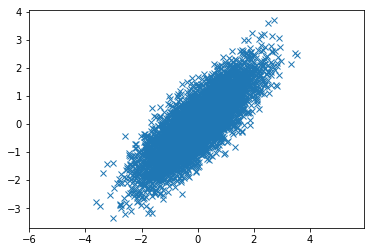

array([[-1.62395312, -2.55735793],
       [-0.1780108 , -0.98014711],
       [-0.56014767,  1.42198698],
       [ 1.28553797,  0.82981295],
       [-1.00147759, -0.22864883]])

In [3]:
mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]

X = np.random.multivariate_normal(mean, cov, 5000)

temp = X.T
plt.plot(temp[0], temp[1], 'x')
plt.axis('equal')
plt.show()
X[:5,:]

In [4]:
class Dataset2D(Dataset):
    def __init__(self, data):
        mean = [0, 0]
        cov = [[1, 0.8], [0.8, 1]]
        self.size = len(data)
        self.origX = data 
        self.X = torch.tensor(self.origX).float()

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.X[idx, :]

In [5]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlow2D(nn.Module):
    def __init__(self, num_coupling, width):
        super(NormalizingFlow2D, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(1, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(1, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True

    def forward(self, x):
        if model.training:
            s_vals = []
            y1, y2 = x[:, :1], x[:, 1:]
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :1], x[:, 1:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer, report_iters=10):
    size = len(dataloader)
    for batch, X in enumerate(dataloader):
        # Transfer to GPU
        X = X.to(device)
        
        # Compute prediction and loss
        y, s = model(X)
        loss = loss_fn(y, s, batch_size)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            y, s = model(X)
            test_loss += loss_fn(y, s, batch_size)

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [7]:
def loss_fn(y, s, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2
    logpx = -torch.sum(0.5 * y**2)
    det = torch.sum(s)
    
    ret = -(logpx + det)
    return torch.div(ret, batch_size)

# 2D Bivariate Gaussian 

In [8]:
learning_rate = 0.0005
batch_size = 100
epochs = 3

model = NormalizingFlow2D(4, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]
training_data = Dataset2D(np.random.multivariate_normal(mean, cov, 20000))
test_data = Dataset2D(np.random.multivariate_normal(mean, cov, 5000))
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
 
print("Done!")

Epoch 1
-------------------------------
loss: 1.124544  [    0/  200]
loss: 1.216799  [   10/  200]
loss: 0.934633  [   20/  200]
loss: 0.961509  [   30/  200]
loss: 1.016676  [   40/  200]
loss: 0.846797  [   50/  200]
loss: 0.832622  [   60/  200]
loss: 0.926843  [   70/  200]
loss: 0.946146  [   80/  200]
loss: 0.800166  [   90/  200]
loss: 0.576516  [  100/  200]
loss: 0.709195  [  110/  200]
loss: 0.749750  [  120/  200]
loss: 0.633022  [  130/  200]
loss: 0.605798  [  140/  200]
loss: 0.610660  [  150/  200]
loss: 0.580594  [  160/  200]
loss: 0.601523  [  170/  200]
loss: 0.369261  [  180/  200]
loss: 0.515325  [  190/  200]
Test Error: 
 Avg loss: 0.497921 

Epoch 2
-------------------------------
loss: 0.434135  [    0/  200]
loss: 0.528876  [   10/  200]
loss: 0.431936  [   20/  200]
loss: 0.753921  [   30/  200]
loss: 0.547457  [   40/  200]
loss: 0.427658  [   50/  200]
loss: 0.592629  [   60/  200]
loss: 0.570688  [   70/  200]
loss: 0.572677  [   80/  200]
loss: 0.554517 

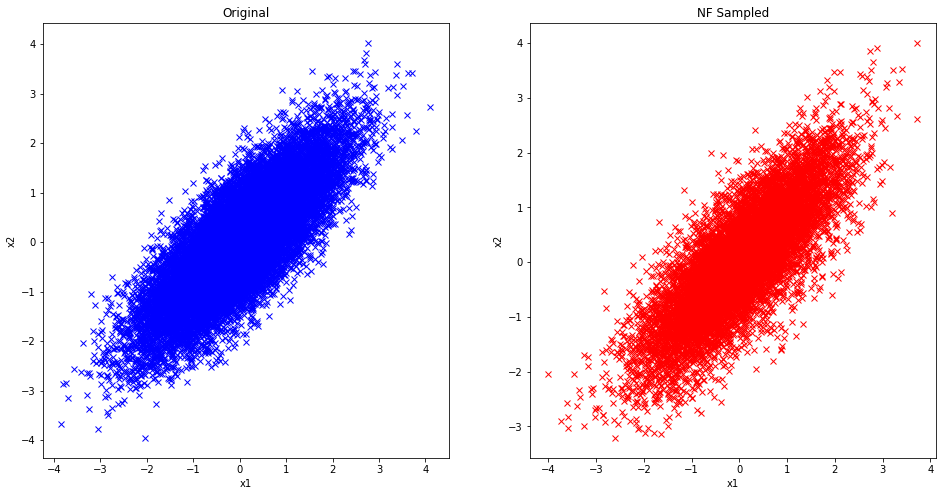

In [9]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,8))

# subplot1
ax1.set_title("Original")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

data = training_data.origX.T
ax1.plot(data[0], data[1], 'x', color='blue')

# subplot2
model.eval()
ax2.set_title("NF Sampled")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
mean = [0, 0]
cov = [[1, 0], [0, 1]]
with torch.no_grad():
    X = torch.Tensor(np.random.multivariate_normal(mean, cov, 10000)).to(device)
    Y = model(X)
samples = Y.cpu().numpy().T
ax2.plot(samples[0], samples[1], 'x', color='red')

# Scikit 2D Artificial Datasets

In [33]:
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

n_samples = 10000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)[0]
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)[0]
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)[0]
no_structure = np.random.rand(n_samples, 2)

In [51]:
learning_rate = 0.001
batch_size = 1000
epochs = 100

datasets = [('Noisy Circles', noisy_circles), 
            ('Noisy Moons', noisy_moons),
            ('Blobs', blobs),
            ('Random', no_structure)]
models = []
orig_data = []
for name, dataset in datasets:
    model = NormalizingFlow2D(32, 20).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    training_data = Dataset2D(dataset)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
   
    print(f"\n======================================\n{name}\n======================================")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, report_iters=1)
        
    models.append(model)
    orig_data.append(training_data.origX)
    break


Noisy Circles
Epoch 1
-------------------------------
loss: 0.900167  [    0/   10]
loss: 0.596815  [    1/   10]
loss: 0.365666  [    2/   10]
loss: 0.196012  [    3/   10]
loss: 0.115769  [    4/   10]
loss: 0.024963  [    5/   10]
loss: -0.006315  [    6/   10]
loss: -0.059884  [    7/   10]
loss: -0.125013  [    8/   10]
loss: -0.124433  [    9/   10]
Epoch 2
-------------------------------
loss: -0.152026  [    0/   10]
loss: -0.118018  [    1/   10]
loss: -0.119396  [    2/   10]
loss: -0.121839  [    3/   10]
loss: -0.115504  [    4/   10]
loss: -0.096317  [    5/   10]
loss: -0.129083  [    6/   10]
loss: -0.147895  [    7/   10]
loss: -0.133618  [    8/   10]
loss: -0.152710  [    9/   10]
Epoch 3
-------------------------------
loss: -0.186091  [    0/   10]
loss: -0.198572  [    1/   10]
loss: -0.147142  [    2/   10]
loss: -0.178178  [    3/   10]
loss: -0.162754  [    4/   10]
loss: -0.194401  [    5/   10]
loss: -0.177519  [    6/   10]
loss: -0.182888  [    7/   10]
los

loss: -0.617323  [    1/   10]
loss: -0.595736  [    2/   10]
loss: -0.626090  [    3/   10]
loss: -0.575986  [    4/   10]
loss: -0.620625  [    5/   10]
loss: -0.581671  [    6/   10]
loss: -0.606738  [    7/   10]
loss: -0.592690  [    8/   10]
loss: -0.624268  [    9/   10]
Epoch 25
-------------------------------
loss: -0.604991  [    0/   10]
loss: -0.588864  [    1/   10]
loss: -0.610208  [    2/   10]
loss: -0.591828  [    3/   10]
loss: -0.610336  [    4/   10]
loss: -0.625204  [    5/   10]
loss: -0.630257  [    6/   10]
loss: -0.606333  [    7/   10]
loss: -0.605055  [    8/   10]
loss: -0.624450  [    9/   10]
Epoch 26
-------------------------------
loss: -0.655598  [    0/   10]
loss: -0.595869  [    1/   10]
loss: -0.638250  [    2/   10]
loss: -0.635876  [    3/   10]
loss: -0.603011  [    4/   10]
loss: -0.626338  [    5/   10]
loss: -0.650095  [    6/   10]
loss: -0.610032  [    7/   10]
loss: -0.633603  [    8/   10]
loss: -0.610727  [    9/   10]
Epoch 27
----------

loss: -0.845525  [    5/   10]
loss: -0.822277  [    6/   10]
loss: -0.798610  [    7/   10]
loss: -0.876031  [    8/   10]
loss: -0.842796  [    9/   10]
Epoch 48
-------------------------------
loss: -0.824863  [    0/   10]
loss: -0.844437  [    1/   10]
loss: -0.829288  [    2/   10]
loss: -0.851175  [    3/   10]
loss: -0.838986  [    4/   10]
loss: -0.831519  [    5/   10]
loss: -0.884164  [    6/   10]
loss: -0.866099  [    7/   10]
loss: -0.834907  [    8/   10]
loss: -0.885994  [    9/   10]
Epoch 49
-------------------------------
loss: -0.855389  [    0/   10]
loss: -0.892190  [    1/   10]
loss: -0.870861  [    2/   10]
loss: -0.869055  [    3/   10]
loss: -0.891954  [    4/   10]
loss: -0.843280  [    5/   10]
loss: -0.893935  [    6/   10]
loss: -0.870801  [    7/   10]
loss: -0.853329  [    8/   10]
loss: -0.863809  [    9/   10]
Epoch 50
-------------------------------
loss: -0.903159  [    0/   10]
loss: -0.895711  [    1/   10]
loss: -0.884813  [    2/   10]
loss: -0.

loss: -0.940346  [    9/   10]
Epoch 71
-------------------------------
loss: -0.951828  [    0/   10]
loss: -0.987796  [    1/   10]
loss: -0.986706  [    2/   10]
loss: -1.012180  [    3/   10]
loss: -0.966207  [    4/   10]
loss: -0.986938  [    5/   10]
loss: -0.982939  [    6/   10]
loss: -0.993783  [    7/   10]
loss: -0.999802  [    8/   10]
loss: -1.002906  [    9/   10]
Epoch 72
-------------------------------
loss: -1.019664  [    0/   10]
loss: -0.982147  [    1/   10]
loss: -0.997263  [    2/   10]
loss: -1.016595  [    3/   10]
loss: -0.937478  [    4/   10]
loss: -0.999112  [    5/   10]
loss: -0.991755  [    6/   10]
loss: -0.974991  [    7/   10]
loss: -0.957966  [    8/   10]
loss: -1.011823  [    9/   10]
Epoch 73
-------------------------------
loss: -0.909148  [    0/   10]
loss: -1.005571  [    1/   10]
loss: -1.009350  [    2/   10]
loss: -0.974344  [    3/   10]
loss: -1.021558  [    4/   10]
loss: -0.930215  [    5/   10]
loss: -0.969295  [    6/   10]
loss: -0.

loss: -1.039257  [    3/   10]
loss: -1.016269  [    4/   10]
loss: -1.034497  [    5/   10]
loss: -0.987983  [    6/   10]
loss: -1.078533  [    7/   10]
loss: -1.064349  [    8/   10]
loss: -1.063316  [    9/   10]
Epoch 95
-------------------------------
loss: -1.064870  [    0/   10]
loss: -0.970052  [    1/   10]
loss: -1.007887  [    2/   10]
loss: -1.031902  [    3/   10]
loss: -1.049444  [    4/   10]
loss: -1.089075  [    5/   10]
loss: -1.028019  [    6/   10]
loss: -1.043973  [    7/   10]
loss: -0.987461  [    8/   10]
loss: -1.054029  [    9/   10]
Epoch 96
-------------------------------
loss: -1.064784  [    0/   10]
loss: -0.986239  [    1/   10]
loss: -1.027687  [    2/   10]
loss: -1.052609  [    3/   10]
loss: -1.045873  [    4/   10]
loss: -0.977521  [    5/   10]
loss: -1.020975  [    6/   10]
loss: -0.972242  [    7/   10]
loss: -1.058611  [    8/   10]
loss: -1.075238  [    9/   10]
Epoch 97
-------------------------------
loss: -1.029336  [    0/   10]
loss: -1.

IndexError: list index out of range

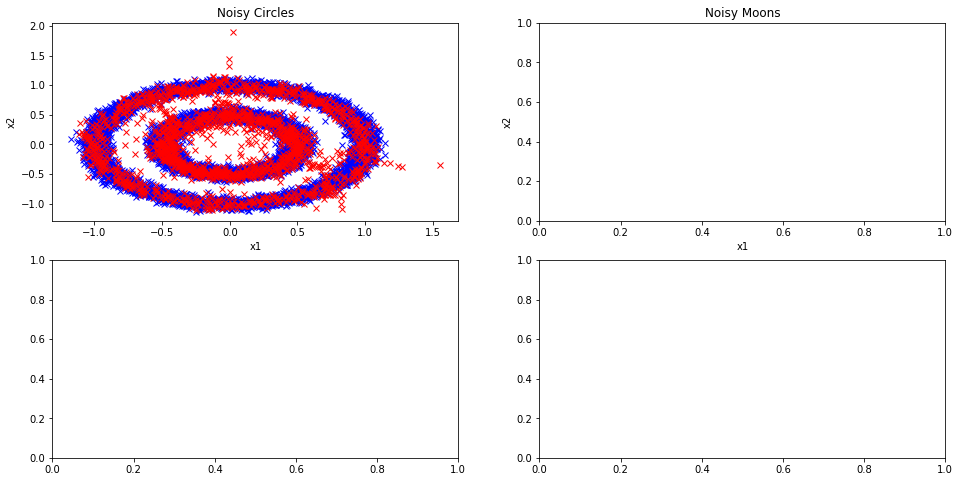

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

for i, ((name, _), ax) in enumerate(zip(datasets, [ax1, ax2, ax3, ax4])):
    # subplot1
    ax.set_title(name)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    
    data = orig_data[i].T
    ax.plot(data[0], data[1], 'x', color='blue')
    
    # subplot2
    model = models[i].eval()
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    with torch.no_grad():
        X = torch.Tensor(np.random.multivariate_normal(mean, cov, 2000)).to(device)
        Y = model(X)
    samples = Y.cpu().numpy().T
    ax.plot(samples[0], samples[1], 'x', color='red')

# 2022-01-06

* Changed to use backbone with tanh * learnable scaling factor
* Added a residual connection
* Experimented with a few variations, looks like coupling(32), width(20) works with LR=0.001 and epochs=100 (main thing was giving it enough epochs to run with a small enough LR)
* More epochs gave a reasonable noisy moon too

TODO:

* Check this settings on the other ones too (takes longer to train so I was impatient)
* Will check if the tanh * learnable and/or residual did anything, questionable

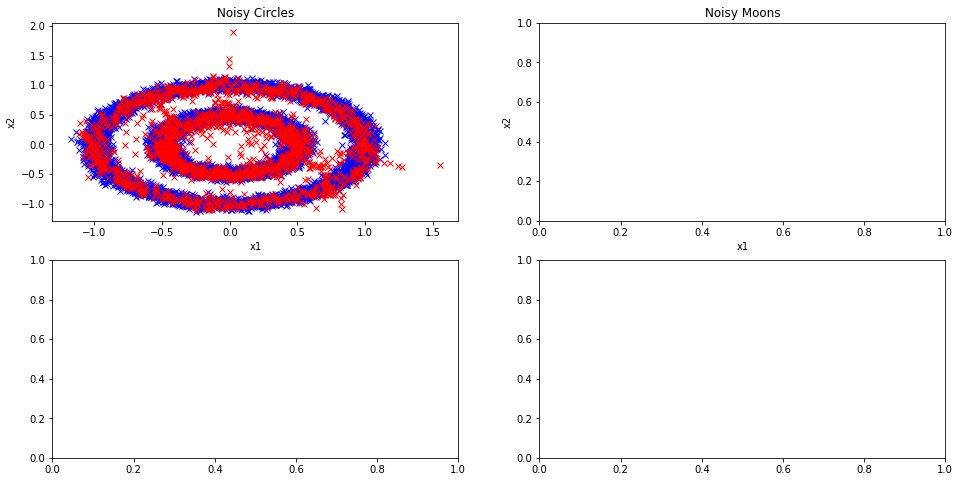

# 2022-01-04

* Tried increasing coupling layers (16) + width(20) but still can't get a clean break
* Can sort of generate Noisy Moons and Blobs, but Noisy circles looks mostly like noise (Random looks ok except for periphery
* Change to tanh * scaling constant instead for s?  That's what they used in the paper
* Interestingly, it would make it much easier if I could map it to more than 2D, but in the paper they have an example where somehow they are able to do it, but it might have been an illustration and not a real run they did 

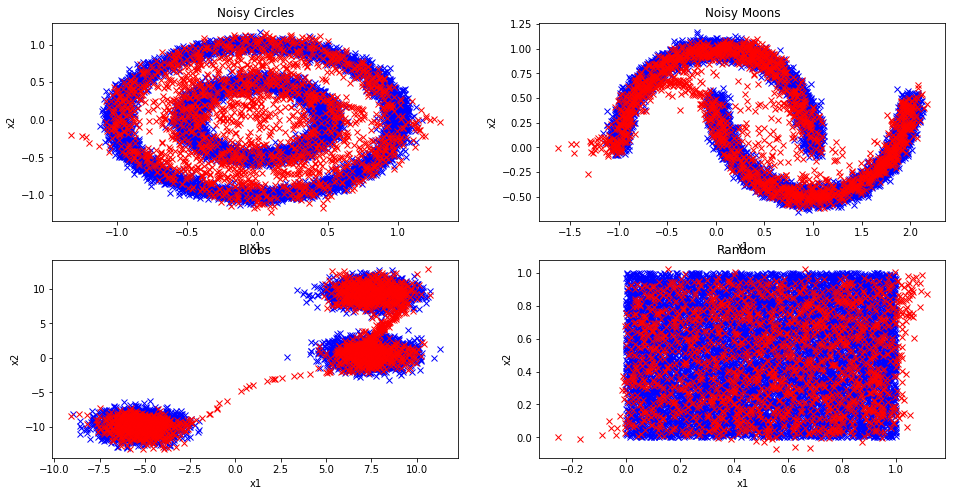